In [256]:
import os
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import spearmanr
import pickle
import seg_metrics.seg_metrics as sg

In [257]:
DATASET_ID = 144
TEST_ID = 1

In [258]:
prediction_img = nib.load('/mnt/data-ssd-4t/datasets/RNSH_HFlung/nnU-Net-processing/nnUNet_predictions/Dataset{}_RNSH_HFlung/post/RNSH_HFlung_{:04d}.nii.gz'.format(DATASET_ID, TEST_ID)).get_fdata()


In [259]:
label_img = nib.load('/mnt/data-ssd-4t/datasets/RNSH_HFlung/nnU-Net-processing/nnUNet_raw/Dataset{}_RNSH_HFlung/labelsTs/RNSH_HFlung_{:04d}.nii.gz'.format(DATASET_ID, TEST_ID)).get_fdata()

In [260]:
DISPLAY_IDX = 100

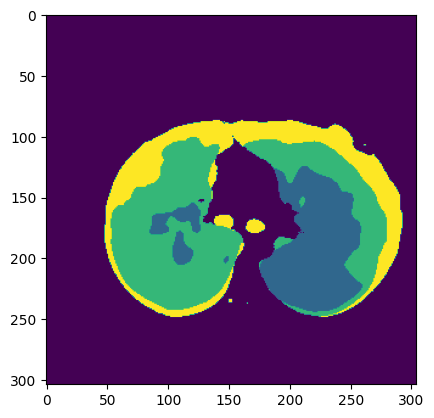

In [261]:
plt.imshow(label_img[:,:,DISPLAY_IDX])
plt.show()

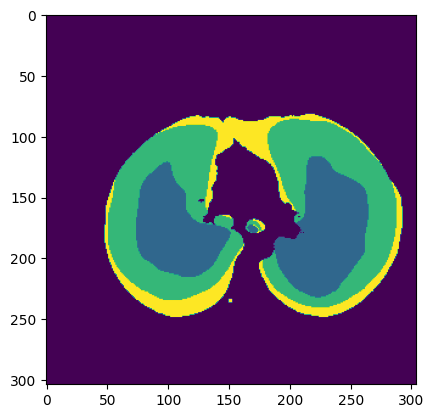

In [262]:
plt.imshow(prediction_img[:,:,DISPLAY_IDX])
plt.show()

In [263]:
seg = prediction_img.ravel()
gt = label_img.ravel()

In [264]:
foreground_idxs = gt > 0

sp = spearmanr(seg[foreground_idxs], gt[foreground_idxs])
print('Spearman')
print(np.round(sp[0],2))

Spearman
0.49


In [265]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [266]:
cm = confusion_matrix(label_img.ravel(), prediction_img.ravel())
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

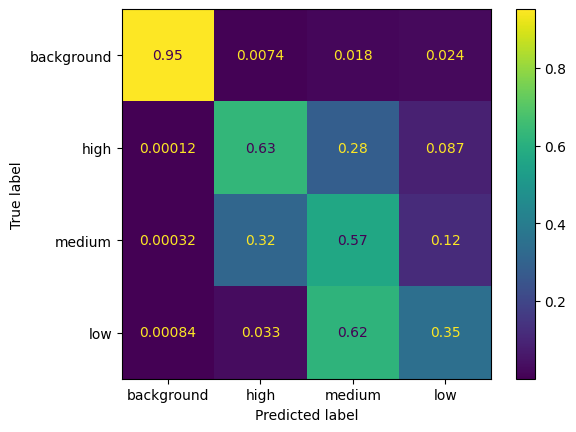

In [267]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['background','high','medium','low'])
disp.plot()
plt.show()

In [268]:
dsc = {}
print('DSC')
for idx,label in enumerate(['high','medium','low']):
    k = idx+1
    dice = np.sum(seg[gt==k]==k)*2.0 / (np.sum(seg[seg==k]==k) + np.sum(gt[gt==k]==k))
    dsc[label] = dice
    print('{}: {}'.format(label, round(dice,2)))

DSC
high: 0.58
medium: 0.46
low: 0.36


In [269]:
labels = [0, 1, 2, 3]

metrics = sg.write_metrics(labels=labels,
                  gdth_img=label_img,
                  pred_img=prediction_img,
                  csv_file=None,
                  metrics=['vs'])

1it [00:05,  5.38s/it]


In [270]:
vs = metrics[0]['vs']
print('volume similarity')
print('high: {}'.format(round(vs[1],2)))
print('medium: {}'.format(round(vs[2],2)))
print('low: {}'.format(round(vs[3],2)))

volume similarity
high: -0.17
medium: -0.36
low: 0.07


#### calculate the mean performance over all training sets

In [271]:
ANALYSIS_DIR = '/home/daryl/analysis'

In [272]:
if not os.path.exists(ANALYSIS_DIR):
    os.makedirs(ANALYSIS_DIR)
    
ANALYSIS_FILE = '{}/nnunet-metrics.pkl'.format(ANALYSIS_DIR)
patient_d = {'dataset_id':DATASET_ID, 'test_id':TEST_ID, 
             'confusion_matrix':cm, 'spearman_correlation':np.round(sp[0],2), 
             'DSC_low':np.round(dsc['low'],2), 'DSC_medium':np.round(dsc['medium'],2), 'DSC_high':np.round(dsc['high'],2),
             'VS_low':np.round(vs[3],2), 'VS_medium':np.round(vs[2],2), 'VS_high':np.round(vs[1],2),
            }

if os.path.isfile(ANALYSIS_FILE):
    with open(ANALYSIS_FILE, 'rb') as f:
        analysis_d = pickle.load(f)
else:
    analysis_d = {}

patient_id = '{:03d}-{:02d}'.format(DATASET_ID, TEST_ID)
analysis_d[patient_id] = patient_d

with open(ANALYSIS_FILE, 'wb') as f:
        pickle.dump(analysis_d, f)

In [273]:
print('Spearman correlation')
print('mean {}, std {}'.format(round(np.mean([value['spearman_correlation'] for key, value in analysis_d.items()]) ,2), round(np.std([value['spearman_correlation'] for key, value in analysis_d.items()]), 2)))
print()
print('DSC')
print('high {}, std {}'.format(round(np.mean([value['DSC_high'] for key, value in analysis_d.items()]) ,2), round(np.std([value['DSC_high'] for key, value in analysis_d.items()]), 2)))
print('medium {}, std {}'.format(round(np.mean([value['DSC_medium'] for key, value in analysis_d.items()]) ,2), round(np.std([value['DSC_medium'] for key, value in analysis_d.items()]), 2)))
print('low {}, std {}'.format(round(np.mean([value['DSC_low'] for key, value in analysis_d.items()]) ,2), round(np.std([value['DSC_low'] for key, value in analysis_d.items()]), 2)))
print()
print('volume similarity')
print('high {}, std {}'.format(round(np.mean([value['VS_high'] for key, value in analysis_d.items()]) ,2), round(np.std([value['VS_high'] for key, value in analysis_d.items()]), 2)))
print('medium {}, std {}'.format(round(np.mean([value['VS_medium'] for key, value in analysis_d.items()]) ,2), round(np.std([value['VS_medium'] for key, value in analysis_d.items()]), 2)))
print('low {}, std {}'.format(round(np.mean([value['VS_low'] for key, value in analysis_d.items()]) ,2), round(np.std([value['VS_low'] for key, value in analysis_d.items()]), 2)))


Spearman correlation
mean 0.44, std 0.07

DSC
high 0.57, std 0.05
medium 0.48, std 0.05
low 0.48, std 0.06

volume similarity
high 0.08, std 0.21
medium -0.15, std 0.16
low -0.06, std 0.13


In [274]:
cm_mean = np.mean([value['confusion_matrix'] for key, value in analysis_d.items()], axis=0)

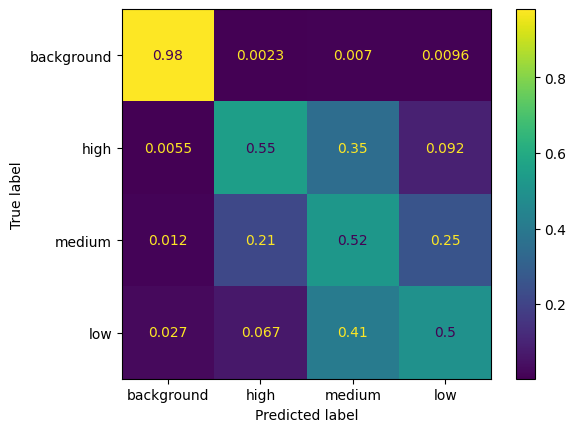

In [275]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm_mean, display_labels=['background','high','medium','low'])
disp.plot()
plt.show()